In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Longstaff-Schwartz Method for American Option Pricing

This notebook implements the **Longstaff-Schwartz algorithm**, a regression-based Monte Carlo method used to price American-style options.

Unlike the binomial tree, which suffers in high dimensions, this method allows:
- Efficient simulation of asset paths.
- Approximation of continuation values via regression.
- Estimation of an optimal stopping strategy.

The implementation is based on the original paper:
> Longstaff, F. A., & Schwartz, E. S. (2001). "Valuing American Options by Simulation: A Simple Least-Squares Approach"


## Asset

This class simulates asset price trajectories under the risk-neutral measure, using a discretized geometric Brownian motion (GBM).

**Attributes:**
- `s0` : Initial asset price.
- `r` : Constant risk-free interest rate.
- `sigma` : Volatility of the asset.
- `div` : Continuous dividend yield.
- `T` : Maturity of the option (in years).
- `N` : Number of time steps.
- `M` : Number of Monte Carlo paths.
- `delta` : Time step size $\Delta_t = T / N$

In [2]:
class Asset:
    def __init__(self, s0, r, sigma, div = 0, T = 1, N = 10, M = 8192, d = 1):
        self.N = N
        self.M = M
        self.d = d
        self.T = T
        self.delta = T / N
        self.s0 = s0
        self.r = r
        self.sigma = sigma
        self.div = div

    def get_noise(self):
        return np.random.normal(0, 1, (self.N + 1, self.M, self.d))

    def brownian_paths(self, noise):
        dB = np.zeros((self.N + 1, self.M, self.d))
        dB[1:] = np.sqrt(self.delta) * noise[1:]
        B = np.cumsum(dB, axis = 0)
        return B

    def asset_paths(self, noise):
        B = self.brownian_paths(noise)
        tn = (np.arange(self.N + 1) * self.delta)[:, None, None]
        S = self.s0 * np.exp((self.r - self.div - 0.5 * self.sigma ** 2) * tn + self.sigma * B)
        return S

## Option Classes

These classes define the discounted payoff structure of European or American options (with early exercise possibility), where the underlying is the **maximum over `d` assets**.

Each option stores:
- A reference to the `Asset` instance.
- The strike price `K`.

- Implements :
  - `payoff(X, n)` – computes the discounted payoff,

**Payoff formulas :**
- Put : $\max(K - f(S), 0)$
- Call : $\max(f(S) - K, 0)$

Where $f(S)$ is the scalar feature extracted from the $d$-dimensional asset vector $S$ (e.g., $\max(S_1, \dots, S_d)$).

In [12]:
class MaxPutOption():
    def __init__(self, asset_instance, K):
        self.asset_instance = asset_instance
        self.K = K

    def payoff(self, X, n = None, discounted = True):
        # X shape : (N + 1, M, d)
        # return shape if n not None : (M)
        # return shape if n is None : (N + 1, M)
        max_value = np.max(X, axis = -1)
        payoff_value = np.maximum(self.K - max_value, 0)
        if discounted :
            tn = (np.arange(X.shape[0]) * self.asset_instance.delta)[:, None]  
            payoff_value = np.exp(- self.asset_instance.r * tn) * payoff_value

        return payoff_value[n] if n is not None else payoff_value
    
class MaxCallOption():
    def __init__(self, asset_instance, K):
        self.asset_instance = asset_instance
        self.K = K

    def payoff(self, X, n = None, discounted = True):
        # X shape : (N + 1, M, d)
        # return shape if n not None : (M)
        # return shape if n is None : (N + 1, M)
        max_value = np.max(X, axis = -1)
        payoff_value =  np.maximum(max_value - self.K, 0)
        if discounted:
            tn = (np.arange(X.shape[0]) * self.asset_instance.delta)[:, None]
            payoff_value = np.exp(- self.asset_instance.r * tn) * payoff_value

        return payoff_value[n] if n is not None else payoff_value

## LongstaffSchwartzPricer

This class implements the Longstaff-Schwartz method to estimate the price of American options via least-squares regression.

### Main methods:

- `_polynomial_basis(x)` : Returns a basis of functions $(1, x, x^2, x^3)$ evaluated at `x`.
- `_regression_coefficients(payoff, x)` : Fits continuation values by regressing discounted payoff on the basis.
- `_approximate_continuation_value(x, theta)` : Uses regression coefficients to estimate the continuation value at `x`.

The regression is done **backward in time**, from $t_N$ to $t_1$, to approximate the optimal stopping policy.

## Pricing Logic

### `compute_exercise_policy(X)` :
- For each time step going backward :
  - Regress the future payoffs on current state to estimate continuation value.
  - Decide whether to exercise or not by comparing payoff to continuation value.
  - Update `tau_opt` (optimal stopping time) and associated `payoff_opt`.

### `get_price()` :
- Generates new Monte Carlo paths.
- Calls `compute_exercise_policy`.
- Optionally plots the continuation value curves.
- Returns the estimated price and confidence interval.

### `plot_value_functions()` :
- Plots $V_n(S) = \max(\text{payoff}, \text{continuation value})$ for each time step.
- Useful for visualizing the optimal exercise boundary.



In [18]:
class LongstaffSchwartzPricer:
    def __init__(self, asset, contract, basis='polynomial'):
        """
        Initializes the Longstaff-Schwartz pricer with the given asset, contract, 
        and choice of basis functions for regression.

        Parameters:
        - asset : The underlying asset object (must implement asset_paths and get_noise).
        - contract : The option contract (must implement payoff method).
        - basis : String indicating the basis type: 
                  'polynomial', 'augmented_polynomial', or 'hermite'.
        """
        self.asset = asset
        self.contract = contract
        if basis == 'polynomial':
            self.basis = self._polynomial_basis
        elif basis == 'augmented_polynomial':
            self.basis = self._augmented_polynomial_basis
        elif basis == 'hermite':
            self.basis = self._hermite_basis
        else:
            raise Exception(f'{basis} doesn\'t exist. Use: polynomial, augmented_polynomial, hermite.')

    def _polynomial_basis(self, x):
        """
        Constructs a polynomial basis up to degree 3 for input x.

        Parameters:
        - x : np.ndarray of shape (M, d), asset prices at a given timestep.

        Returns:
        - basis : np.ndarray of shape (M, p), with p the number of polynomial terms.
        """
        return np.concatenate([np.ones((x.shape[0], 1)), x, x**2, x**3], axis=1)

    def _augmented_polynomial_basis(self, x):
        """
        Polynomial basis with an additional feature from the option's (undiscounted) payoff.

        Parameters:
        - x : np.ndarray of shape (M, d), asset prices.

        Returns:
        - basis : np.ndarray of shape (M, p + 1)
        """
        return np.concatenate([
            np.ones((x.shape[0], 1)), 
            x, 
            x**2, 
            x**3, 
            self.contract.payoff(x, discounted=False).reshape(-1, 1)], axis=1)

    def _hermite_basis(self, x):
        """
        Hermite-like orthogonal polynomial basis up to degree 4.

        Parameters:
        - x : np.ndarray of shape (M, d), asset prices.

        Returns:
        - basis : np.ndarray of shape (M, p)
        """
        return np.concatenate([
            np.ones((x.shape[0], 1)), 
            x, 
            x**2 - 1, 
            x**3 - 3*x, 
            x**4 - 6*x**2 + 3], axis=1)

    def _regression_coefficients(self, payoff, x):
        """
        Computes regression coefficients for continuation value approximation.

        Parameters:
        - payoff : np.ndarray of shape (M,), continuation values.
        - x : np.ndarray of shape (M, d), asset prices.

        Returns:
        - theta : np.ndarray of shape (p,), regression coefficients.
        """
        basis = self.basis(x)
        return np.linalg.lstsq(basis, payoff, rcond=None)[0]

    def _approximate_continuation_value(self, x, theta):
        """
        Computes the estimated continuation value using the basis and coefficients.

        Parameters:
        - x : np.ndarray of shape (M, d), asset prices.
        - theta : np.ndarray of shape (p,), regression coefficients.

        Returns:
        - continuation_value : np.ndarray of shape (M,)
        """
        basis = self.basis(x)
        return basis @ theta

    def compute_exercise_policy(self, X):
        """
        Computes the optimal exercise strategy based on continuation value regression.

        Parameters:
        - X : np.ndarray of shape (N + 1, M, d), simulated asset paths.

        Returns:
        - thetas : list of regression coefficients per timestep.
        - payoff_opt : np.ndarray of shape (M,), optimal payoffs.
        """
        payoffs = self.contract.payoff(X)
        thetas = []
        tau_opt = np.full(self.asset.M, self.asset.N, dtype=int)
        payoff_opt = payoffs[self.asset.N].copy()

        for n in reversed(range(1, self.asset.N + 1)):
            x_n = X[n]
            theta_n = self._regression_coefficients(payoff_opt, x_n)
            thetas.append(theta_n)

            cont_val = self._approximate_continuation_value(x_n, theta_n)
            exercise_now = payoffs[n] >= cont_val
            tau_opt[exercise_now] = n
            payoff_opt[exercise_now] = payoffs[n, exercise_now]

        return thetas[::-1], payoff_opt

    def get_price(self, confidence_level=0.95, plot_value_functions=False):
        """
        Computes the option price and confidence interval via regression-based Longstaff-Schwartz.

        Parameters:
        - confidence_level : float, e.g., 0.95 for 95% confidence.
        - plot_value_functions : bool, whether to plot the value functions (only if d = 1).

        Returns:
        - Prints estimated price and confidence interval.
        """
        print(f"Pricing the option via LongStaffSchwartz multidimensional regression on {self.basis.__name__.replace('_', ' ').strip()}...")

        noise = self.asset.get_noise()
        X = self.asset.asset_paths(noise)
        thetas, payoff_opt = self.compute_exercise_policy(X)

        mean_payoff = np.mean(payoff_opt)
        variance = np.var(payoff_opt, ddof=1)
        alpha = 1 - confidence_level
        quantile = stats.norm.ppf(1 - alpha / 2)
        ci_lower = mean_payoff - quantile * np.sqrt(variance / payoff_opt.size)
        ci_upper = mean_payoff + quantile * np.sqrt(variance / payoff_opt.size)

        print(f"\n=== Option Pricing Results ===")
        print(f"Estimated Price     : {mean_payoff:.6f}")
        print(f"Confidence Level    : {confidence_level*100:.1f}%")
        print(f"Confidence Interval : [{ci_lower:.6f}, {ci_upper:.6f}]\n")
    
        if plot_value_functions:
            assert self.asset.d == 1, "Can only plot value functions for d = 1"
            print(f"Plotting continuation values...")
            self.plot_value_functions(thetas)

    def plot_value_functions(self, thetas):
        """
        Plots the approximated value function V_n at each timestep (only for d = 1).

        Parameters:
        - thetas : list of regression coefficients.
        """
        xx = np.linspace(self.contract.K - 20, self.contract.K + 20, 1000).reshape(-1, 1)

        _, ax = plt.subplots(figsize=(8, 5))
        ax.plot(xx, self.contract.payoff(xx, self.asset.N))

        for n in range(1, self.asset.N):
            C_n = self._approximate_continuation_value(xx, thetas[n])
            payoff_value = self.contract.payoff(xx, n)
            V_n = np.maximum(payoff_value, C_n)
            ax.plot(xx, V_n, label=fr"$V_{{{n}}}$")

        ax.set_xlabel("Asset price")
        ax.set_ylabel("Value")
        ax.set_title("Approximated value functions")
        plt.show()

### Importance of Basis Function Choice in Regression Accuracy

We observe that the choice of basis functions has a significant impact on the quality of the option pricing. 
In particular, adding a non-linear component inspired by the payoff function such as $\max(x, 0)$ substantially improves the approximation. This enhancement allows the estimated continuation values to more closely match the actual payoff function.

Pricing the option via LongStaffSchwartz multidimensional regression on polynomial basis...

=== Option Pricing Results ===
Estimated Price     : 7.790206
Confidence Level    : 95.0%
Confidence Interval : [7.767536, 7.812875]

Plotting continuation values...


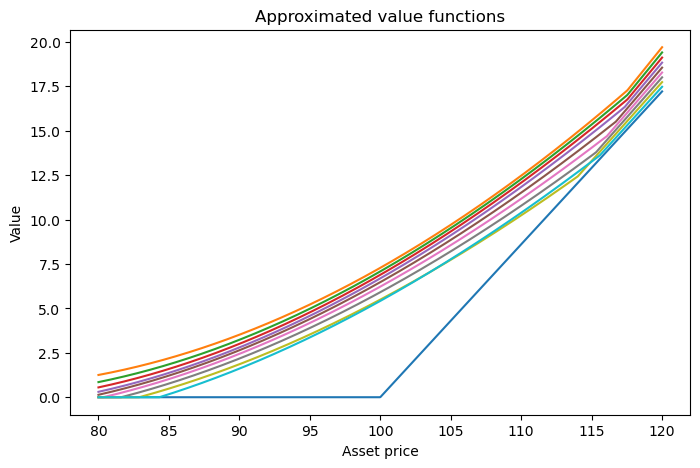

Pricing the option via LongStaffSchwartz multidimensional regression on augmented polynomial basis...

=== Option Pricing Results ===
Estimated Price     : 7.932145
Confidence Level    : 95.0%
Confidence Interval : [7.908961, 7.955329]

Plotting continuation values...


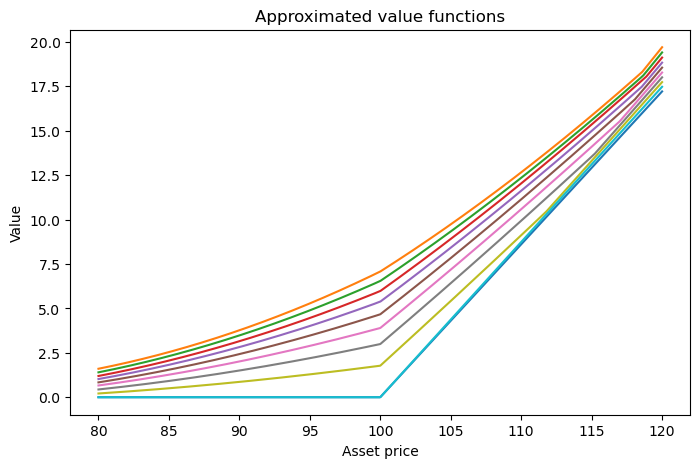

In [19]:
S = Asset(s0 = 100, 
          r = 0.05, 
          div = 0.1, 
          sigma = 0.2, 
          T = 3, 
          N = 10, 
          M = 1_000_000,
          d = 1)

contract = MaxCallOption(S, K = 100)
pricer = LongstaffSchwartzPricer(S, contract, basis = 'polynomial')
pricer.get_price(confidence_level = 0.95, plot_value_functions = True)

pricer = LongstaffSchwartzPricer(S, contract, basis = 'augmented_polynomial')
pricer.get_price(confidence_level = 0.95, plot_value_functions = True)

### Extension to Multidimensional Setting

We now extend the Longstaff-Schwartz regression method to the case where the underlying asset is multidimensional (i.e., $d > 1$).
In this setting, the regression is performed on all dimensions jointly, allowing for more complex payoff structures and dependencies between assets.

In [20]:
S = Asset(s0 = 100, 
          r = 0.05, 
          div = 0.1, 
          sigma = 0.2, 
          T = 3, 
          N = 10, 
          M = 1_000_000,
          d = 3)

contract = MaxCallOption(S, K = 100)
pricer = LongstaffSchwartzPricer(S, contract, basis = 'augmented_polynomial')
pricer.get_price(confidence_level = 0.95)

Pricing the option via LongStaffSchwartz multidimensional regression on augmented polynomial basis...

=== Option Pricing Results ===
Estimated Price     : 18.611615
Confidence Level    : 95.0%
Confidence Interval : [18.576753, 18.646477]



In [21]:
contract = MaxPutOption(S, K = 100)
pricer = LongstaffSchwartzPricer(S, contract, basis = 'augmented_polynomial')
pricer.get_price(confidence_level = 0.95)

Pricing the option via LongStaffSchwartz multidimensional regression on augmented polynomial basis...

=== Option Pricing Results ===
Estimated Price     : 5.583399
Confidence Level    : 95.0%
Confidence Interval : [5.567338, 5.599460]

